In [1]:
from collections import defaultdict
import glob
from itertools import groupby
import operator
import os
import re

import numpy as np
import pandas as pd
import pickle
import random
import sparse
#import tensorly as tl
#import tensorly.decomposition as decomp
import sktensor
import urllib3
#import wget

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import logging
logging.basicConfig(level=logging.DEBUG, 
                    format='%(levelname)-8s [%(lineno)d] %(message)s')

if not os.path.exists('cp_orth.py'):
    wget.download('http://web.stanford.edu/~vsharan/cp_orth.py')
from cp_orth import orth_als

/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
DEBUG    [211] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


In [2]:
names = ['lemma', 'token_freq', 'pos', 'doc_freq', 'normalized']
prevlex = pd.read_csv('/home/makrai/repo/prevlex/PrevLex.txt', sep='\t', header=None, names=names)
prevlex.head()

,lemma,token_freq,pos,doc_freq,normalized
0,abba+hagy,9496,FIN,1258,abba+hagy
1,abba+marad,1277,FIN,620,abba+marad
2,abba+hagyat,45,FIN,41,abba+hagyat
3,abba+fejez,27,UNKNOWN,24,abba+fejez
4,abba+szakad,3,UNKNOWN,3,abba+szakad


In [3]:
class keydefault_dict(dict):
    def __missing__(self, key):
        return ('', key)

def get_prev_verb():
    prev_verb = keydefault_dict()
    for prev_plus_verb in prevlex.lemma:
        prev, verb = prev_plus_verb.split('+')
        prev_verb[prev+verb] = (prev, verb)
    return prev_verb

In [4]:
projdir = '/mnt/permanent/home/makrai/project/verb-tensor'

In [5]:
def mazsola_reader():
    pickle_path = os.path.join(projdir, 'prev_sep/mazsola.pkl')
    if os.path.exists(pickle_path):
        logging.info('Loading mazsola dict from {}'.format(pickle_path))
        return pickle.load(open(pickle_path, mode='rb'))
    logging.info('Reading mazsola...'.format(pickle_path))
    path = '/mnt/permanent/Language/Hungarian/Dic/sass15-535k-igei-szerkezet/mazsola_adatbazis.txt'
    prev_verb = get_prev_verb()
    occurrence = defaultdict(int)#lambda: defaultdict(lambda: defaultdict(int)))
    margianls = [defaultdict(int) for _ in range(4)]
    with open(path) as infile:
        for i, line in enumerate(infile):
            if not i % 500000:
                logging.info('{:.0%}'.format(i/27970403))
            record = defaultdict(str)
            for token in line.strip().split():
                case_stem = re.split('@@', token)
                if len(case_stem) == 1:
                    continue
                try:
                    case, stem = case_stem
                except:
                    logging.warning(line.strip())
                record[case] = stem
            record['prev'], record['verb'] = prev_verb[record['stem']]
            occurrence[record['NOM'], record['prev'], record['verb'], record['ACC']] += 1
            for i, mode in enumerate(['NOM', 'prev', 'verb', 'ACC']):
                margianls[i][record[mode]] += 1            
    result = occurrence, margianls
    pickle.dump(result, open(pickle_path, mode='wb'))
    return result                

In [6]:
def get_tensor(middle_end='sktensor', cutoff=10):
    logging.info('Reweighting: log')
    verb_tensor_path = os.path.join(projdir, 'prev_sep/tensor_{}_{}.pkl').format(
        middle_end, cutoff)
    if os.path.exists(verb_tensor_path):
        logging.info('Loading tensor from {}'.format(verb_tensor_path))
        tensor, indices = pickle.load(open(verb_tensor_path, mode='rb'))
        logging.debug(tensor.shape)
        return tensor, indices
    occurrence, marginals = mazsola_reader()
    def get_index(freq_dict):
        items = sorted(filter(lambda item: item[1] >= cutoff, freq_dict.items()), key=operator.itemgetter(1), 
                       reverse=True)
        logging.debug(items[-3:])
        return dict([(w, i) for i, (w, f) in enumerate(items)])

    coords, data = ([], [], [], []), []
    indices = [get_index(fd) for fd in marginals]
    logging.info('Building tensor...')
    logging.info('  Pupulating lists...')
    for i, ((svo), freq) in enumerate(occurrence.items()):
        if not i % 2000000:
            logging.debug('    {:,}'.format(i))#'{} {}'.format(svo[1], freq))
        for i, word in enumerate(svo):
            if svo[i] not in indices[i]:
                break
        else:
            for i, word in enumerate(svo):
                coords[i].append(indices[i][svo[i]])
            data.append(np.log(freq))
    logging.info('  Creating array')
    shape = tuple(map(len, indices))
    logging.info(shape)
    if middle_end == 'tensorly':
        tensor = sparse.COO(coords, data, shape=shape)#, has_duplicates=False)
    elif middle_end == 'sktensor':
        tensor = sktensor.sptensor(coords, data, shape=shape)
    else:
        raise NotImplementedError
    pickle.dump((tensor, indices), open(verb_tensor_path, mode='wb'))
    logging.info(tensor)
    return tensor, indices

In [7]:
def decomp(cutoff, dim):
    logging.info((cutoff, dim))
    filen_base = os.path.join(projdir, 'prev_sep/decomp_{}_{}').format(cutoff, dim)
    if os.path.isfile('{}.{}'.format(filen_base, 'pkl')):
        logging.info('File exists {} {}'.format(cutoff, dim))
        return
    vtensor, indices = get_tensor(cutoff=cutoff)
    try:
        result = orth_als(vtensor, dim)
        pickle.dump(result, open('{}.{}'.format(filen_base, 'pkl'), mode='wb'))
    except Exception as e:
        with open('{}.{}'.format(filen_base, 'err'), mode='w') as logfile:
            logfile.write('{}'.format(e))
        logging.exception(e)

In [15]:
def show_expers(feature='exectimes'):
    tabular = []
    mx = []
    for filen in glob.glob(os.path.join(projdir, 'prev_sep/decomp_*.pkl')):
        _, cutoff, dim = os.path.splitext(filen)[0].rsplit('_', 2)
        cutoff, dim = map(int, (cutoff, dim))
        ktensor, fit, n_iterations, exectimes = pickle.load(open(filen, mode='rb'))
        tabular.append((cutoff, dim, ktensor.shape))
        mx.append([cutoff, dim, sum(exectimes)/60/60])
    mx = np.array(mx)
    print('\n'.join(map(str, sorted(tabular))))
    plt.scatter(np.array(mx).T[0], mx.T[1], c=mx.T[2])
    plt.colorbar()
    plt.xscale('log')

DEBUG    [506] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f0678d510f0>
DEBUG    [535] Using auto colorbar locator on colorbar
DEBUG    [536] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f0678d510f0>
DEBUG    [692] Setting pcolormesh
DEBUG    [2515] update_title_pos
DEBUG    [2157] vmin 1663.4852598926573 vmax 161368.60743100842
DEBUG    [2212] ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])
DEBUG    [2157] vmin 1663.4852598926573 vmax 161368.60743100842
DEBUG    [2212] ticklocs [200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0, 20000000.0, 30000000.0, 40000000.0, 50000000.0, 60000000.0, 70000000.0, 80000000.0, 90000000.0]


(2048, 2, (1251, 58, 898, 579))
(2048, 3, (1251, 58, 898, 579))
(2048, 5, (1251, 58, 898, 579))
(2048, 10, (1251, 58, 898, 579))
(2048, 25, (1251, 58, 898, 579))
(2048, 50, (1251, 58, 898, 579))
(4096, 2, (622, 48, 616, 243))
(8192, 2, (278, 33, 384, 101))
(16384, 2, (87, 25, 219, 43))
(32768, 2, (24, 16, 120, 16))
(32768, 3, (24, 16, 120, 16))
(32768, 5, (24, 16, 120, 16))
(32768, 10, (24, 16, 120, 16))
(65536, 2, (10, 15, 48, 9))
(65536, 3, (10, 15, 48, 9))
(65536, 4, (10, 15, 48, 9))
(65536, 5, (10, 15, 48, 9))
(131072, 2, (3, 9, 19, 5))


DEBUG    [2157] vmin 1663.4852598926573 vmax 161368.60743100842
DEBUG    [2212] ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])
DEBUG    [2157] vmin 1663.4852598926573 vmax 161368.60743100842
DEBUG    [2212] ticklocs [200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0, 20000000.0, 30000000.0, 40000000.0, 50000000.0, 60000000.0, 70000000.0, 80000000.0, 90000000.0]
DEBUG    [2515] update_title_pos
DEBUG    [2157] vmin 1663.4852598926573 vmax 161368.60743100842
DEBUG    [2212] ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])
DEBUG    [2515] update_title_pos
DEBUG    [2157] vmin 1663.4852598926573 vmax 161368.60743100842
DEBUG    [2212] ticklocs array([1.

DEBUG    [2157] vmin 1663.4852598926573 vmax 161368.60743100842
DEBUG    [2212] ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])
DEBUG    [2157] vmin 1663.4852598926573 vmax 161368.60743100842
DEBUG    [2212] ticklocs [200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0, 20000000.0, 30000000.0, 40000000.0, 50000000.0, 60000000.0, 70000000.0, 80000000.0, 90000000.0]
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2157] vmin 1663.4852598926573 vmax 161368.60743100842
DEBUG    [2212] ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])
DEBUG    [2157] vmin 1663.4852598926573 vmax 161368.60743100842
DEBUG    [2212] ticklocs [200.0, 3

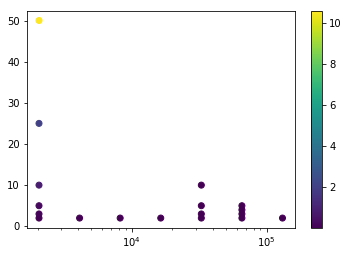

In [16]:
show_expers()

In [10]:
def rand_elem(list1):
    return list1[np.random.randint(0, len(list1))]